In [35]:
import math
import copy
from task import Task
from caseLoader import CaseLoader
from taskType import TaskType
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import sys

In [36]:
MT = 10 # microtick

In [37]:
loader = CaseLoader()
cases = loader.load_test_case("inf_30_30", 0)
cases = [c for c in cases if c.type == TaskType.TIME]

Searching for test cases at:
./test_cases/inf_30_30
Loaded case_group: inf_30_30 - case: 0 test case(s).


In [271]:
def get_ready(task_set, cycle, ready_list):
    for task in task_set:
        if cycle % task.period == 0:
            new_job = copy.deepcopy(task)
            new_job.deadline = new_job.deadline + cycle
            new_job.release_time = cycle
            ready_list.append(new_job)
    
    # sort on deadline
    # https://www.geeksforgeeks.org/sorting-objects-of-user-defined-class-in-python/
    ready_list = sorted(ready_list, key=lambda t: t.deadline) 
    
    return ready_list
        

# ts is set of TT tasks
def edf(ts):
    
    periods = [t.period for t in ts]
    T = math.lcm(*periods) # least common multiple of TT task periods. 2000 mt = 
    #print(T)
    S = [] # schedule will be hyperperiod long. 12 000 microticks == 120 000 microsecs == 120 ms
    ready_list = []
    wcrts = {} # worst case response times
    
    # overvej reset funktioner i task klassen istedet for alle de kopier...
    for t in range(0, T):
        ready_list = get_ready(ts, t, ready_list)
        
        for task in ready_list:
            if task.duration > 0 and task.deadline <= t:
                return [], -1
        
            # job done check response time gt wcrt and remove from ready list
            if task.duration == 0 and task.deadline >= t:
                response_time = t - task.release_time
                
                if task.name not in wcrts or response_time >= wcrts[task.name]:
                    wcrts[task.name] = response_time
                
                ready_list.remove(task)
                
            
        if ready_list == []:
            S.append("IDLE")
            continue
        else:
            # EDF get next job to execute 
            S.append(ready_list[0].name)
            ready_list[0].duration = ready_list[0].duration - 1
    
    if ready_list != []:
        return [], wcrts
    
    return S, wcrts


# ts is set of TT tasks
def edf1(ts):
    periods = [t.period for t in ts]
    T = math.lcm(*periods) # least common multiple of TT task periods. 2000 mt = 
    #print(T)
    S = [] # schedule will be hyperperiod long. 12 000 microticks == 120 000 microsecs == 120 ms
    ready_list = []
    wcrts = {} # worst case response times
    
    # overvej reset funktioner i task klassen istedet for alle de kopier...
    print("HYEORPERIOD IS: ", T)
    for t in range(0, T):
        ready_list = get_ready(ts, t, ready_list)

        for task in ready_list:
            #if task.duration > 0 and task.deadline <= t: # what to do here if we are to go on with infeasible solutios
            #    return [], -1
        
            
        
            # job done check response time gt wcrt and remove from ready list
            if task.duration == 0 and task.deadline >= t:
                response_time = t - task.release_time
                
                if task.name not in wcrts or response_time >= wcrts[task.name][0]:
                    wcrts[task.name] = (response_time, task.deadline)
                
                ready_list.remove(task)
                
            
        if ready_list == []:
            S.append("IDLE")
            continue
        else:
            # EDF get next job to execute 
            S.append(ready_list[0].name)
            ready_list[0].duration = ready_list[0].duration - 1
    
    if ready_list != []:
        return [], wcrts
    
    print("in edf1: ", wcrts)
    
    return S, wcrts


def unpack(task):
    return (task.priority, task.duration, task.period, task.deadline)

#Schedulability of ET tasks under a given polling task
def calculate_schedulabiltiy(ps, task_periods):
    Tp = ps.period
    Dp = ps.deadline
    Cp = ps.duration
    
    response_times = {}
    
    #compute delta and alpha accordingly to [2]
    Delta = Tp + Dp - 2*Cp
    alpha = Cp/Tp
    
    #hyperperiod is lcm of all task periods in T_ET (all values must be from the chosen subset of ET tasks from the .csv)
    periods = []
    for task in task_periods:
        (pi, Ci, Ti, Di) = unpack(task)
        periods.append(Ti)

    hyperperiod = math.lcm(*periods)
    #print("hyperperiod ets is ", hyperperiod)

    #loop
    for task_period in task_periods:
        (pi, Ci, Ti, Di) = unpack(task_period)
        t = 0
        #initialize the response time of ti (task period) to a value exceeding the deadline
        response_time = Di + 1

        #remember we are dealing with constrained deadline tasks for the AdvPoll, hence, in the worst case arrival pattern, the intersection must lie within the hyperperiod if the task is schedulable

        while t <= hyperperiod:
            #the supply at time t ([1])
            supply = alpha*(t-Delta)

            #compute the maximum demand at time t according to Eq. 2
            demand = 0
            for tj in task_periods:
                (pj, Cj, Tj, Dj) = unpack(tj)

                if pj >= pi:
                    demand  = demand + math.ceil(t/Tj)*Cj
            
            #According to lemma 1 of [1], we are searching for the earliest time, when the supply exceeds the demand
            if supply >= demand:
                response_time = t
                response_times[task_period.name] = (response_time, task_period.deadline)
                break
            
            t = t + 1
        
        if response_time > Di:
            return False, response_times
        
    return True, response_times



def cost(tasks):
    
    polling_servers = [ps for ps in tasks if ps.et_subset != None]
    
    l = [calculate_schedulabiltiy(ps, ps.et_subset) for ps in polling_servers]
    # https://www.geeksforgeeks.org/reduce-in-python/
    # create list of bools by applying schedulability check for ets, fold into single bool using and.
    is_schedulable = reduce((lambda a, b : a and b), [element[0] for element in l])
    
    if not is_schedulable:
        return [], float('inf')
    
    sum_wcrts_et = sum([sum([element[1][key] for key in element[1]]) for element in l])
    
    s, wcrts = edf(tasks)
    
    if wcrts == -1:
        return [], float('inf')
    
    sum_wcrts_tt = sum([wcrts[key] for key in wcrts])
    
    return s, sum_wcrts_tt + sum_wcrts_et


def cost_alt(tasks):
    polling_servers = [ps for ps in tasks if ps.et_subset != None]
    
    #l = [calculate_schedulabiltiy(ps, ps.et_subset) for ps in polling_servers]
 
    is_schedulable = True
    normal_sum = 0
    deadlines = 0

    print([t.name for t in tasks])
    s, wcrts = edf1(tasks)
    print(wcrts)
    for key in wcrts:
        print(key)
        print(wcrts[key])
    
    #print("in cost alt now last element of tasks is: ", tasks[-1].name)
    print("in cost alt is pollin server in wcrts?")
    print("tTTps00" in wcrts)
    
    
    #print("in cost_alt wcrts:", wcrts)
    #if wcrts == -1:
    #    return [], float('inf')
    
    normal_sum = 0
    deadlines = 0
    for schedule, wcrts in l:        
        normal_sum += sum([(wcrts[t][0] / wcrts[t][1]) for t in wcrts])
        deadlines +=  sum([wcrts[t][1] for t in wcrts])
    
    #sum_wcrts_tt = sum([wcrts[key] for key in wcrts])
    print(wcrts)
    print("DEADLINES", deadlines )
    print("in cost_alt cost is: ", normal_sum)
    print("normalsum / deadlines", normal_sum / deadlines)
    return s, normal_sum #/ deadlines 

    

In [272]:
#s, wcrts = edf(cases)

In [268]:
print(sum([wcrts[key] for key in wcrts]))

11843


In [252]:
"""
Determine: You will have to design and implement an optimization algorithm that
determines an optimized solution which consists of the following: (i) The number of polling
servers, which then become extra TT tasks. (ii) For each polling server (task), the period,
budget, and deadline, as well as (iii) which sub-sets of ET tasks are handled within the
respective polling servers. Moreover, the TT tasks also need to be schedulable, i.e., given the
found polling tasks (and their parameters), it shall be possible to find (iv) a TT schedule
such that also the TT tasks are schedulable

"""

NUM_PS = 0
BUDGET = 1
PERIOD = 2
DEADLINE = 3
SUBSET = 4

# get a subset of pses from victim and delete these from victim
# -1 to not steal all, max (1, otherthing) to not get rand(1, -x)
def get_subset(s, victim_ps):
    num_et_tasks = rand.randint(1, max(1, len(victim_ps.et_subset) - 1)) 
    new_ps_et_subset = []
        
    for task in victim_ps.et_subset[0:num_et_tasks]:
        new_ps_et_subset.append(task)
        victim_ps.et_subset.remove(task)
        
    return new_ps_et_subset
    
# take polling servers as arg, 
def neighborhood(polling_servers):
    # select randomly a ps then randomly choose to change:
        # num_ps, period, budget, deadline or subset of et_tasks
        # et_tasks will have to take some from another/give 
        # do not worry whether newly generated solution is feasible 
        # return new solution 
    
    # num_ps, period, budget, deadline, subset
    
    # select parameter to change. skip adding/removing ps for now
    parameter = rand.randint(1, 4)
    
    # sel
    victim_ps = polling_servers[rand.randint(0,len(polling_servers)) % len(polling_servers)] # victim to change etc.
    
    # increase or decrease chosen parameter
    sign = 1 if rand.randint(0,1) == 0 else -1
    
    # only adds a polling server. add functionality to remove one and move et subset to other ps
    if parameter == NUM_PS:
        new_ps_et_subset = get_subset(polling_servers, victim_ps)
        new_ps = Task("tTT" + str(rand.randint(0,5000)), 1000, 1000, TaskType.TIME, 7, 1000, new_ps_et_subset)
        
        return polling_servers + [new_ps]
    
    elif parameter == BUDGET:
        victim_ps.duration = max(50, victim_ps.duration + sign * 50)
        victim_ps.duration = 1 if victim_ps.duration == 0 else victim_ps.duration
    
    elif parameter == PERIOD:
        victim_ps.period = max(50, victim_ps.period + sign * 50)
        victim_ps.period = 1 if victim_ps.period == 0 else victim_ps.period
    
    elif parameter == DEADLINE:
        victim_ps.deadline = max(50, victim_ps.deadline + sign * 50)
    
    elif parameter == SUBSET:
        if len(polling_servers) == 1: # if no one to steal from 
            return polling_servers 
        other_ps_victim = polling_servers[rand.randint(0, len(polling_servers)) % len(polling_servers)]

        while other_ps_victim == victim_ps:
            other_ps_victim = polling_servers[rand.randint(0, len(polling_servers)) % len(polling_servers)]
            
        new_ps_et_subset = get_subset(polling_servers, other_ps_victim)
        
        victim_ps.et_subset += new_ps_et_subset
        
    return polling_servers # should be copy no?

In [253]:
rand = random.Random()
    
def p(delta, t):
    return np.exp( -delta / t )

# simulated annealing 
def sa(s0, t, a, stopcriterion_sec, neighborhood_f = None, cost_f=None, log_costs = False):
    # initialize variables
    sec0 = int(time.time())
    sec_now = int(time.time())
    
    # get tt and et tasks
    tt = [t for t in s0 if t.type == TaskType.TIME]
    et = [t for t in s0 if t.type == TaskType.EVENT]
    
    # initialize a single polling server
    # make random initial 
    polling_servers = [Task("tTTps00", 1000, 1000, TaskType.TIME, 7, 1000, et_subset=copy.deepcopy(et))]    
    
    # best solution
    s_best = []
    s_cur = tt[:] + polling_servers
    schedule_best, cost_best = cost_f(tt + polling_servers) # hmm :)
    best_ps_config = []

    # current solution, used in loop
    schedule = schedule_best[:]
    cost_cur = cost_best
    
    print("INITIAL COST IS: ", cost_cur)
    
    #print(cost_cur)
    
    # 1 entry pr. cycle in hyperperiod
    #schedule = []
    
    # for logging purposes
    n_solutions = 0
    cost_log = []
    
    # does not matter if < or <= if 0 then new solution will be selected no matter what     
    while int(time.time()) - sec0 < stopcriterion_sec:
        ps_tmp = neighborhood_f(copy.deepcopy(polling_servers)) # feel like we should call with a copy?
        s_tmp = tt + ps_tmp
        print(s_tmp[-1].name)
        print("done with neighborhood")
        
        #is_schedulable = reduce((lambda a, b : a and b), [cost_f2(ps, ps.et_subset) for ps in ps_tmp])
        
        
        # get schedule and wcrts of each tt
        schedule_tmp, cost_tmp = cost_f(s_tmp)
        print("Done with cost")
        
        #print(cost_tmp)
        
        delta = cost_tmp - cost_cur
        
        n_solutions = n_solutions + 1
        
        # accept randomly drawn solution from current neighborhood if better or with some probability
        if delta <= 0 or p(delta, t) > rand.uniform(0.0, 1.0):
            print(p(delta, t))
            polling_servers = copy.deepcopy(ps_tmp) # all these copies...
            s_cur = tt + polling_servers # update current solution, current set of polling servers, costs & schedule
            cost_cur = cost_tmp
            schedule = schedule_tmp[:]
                        
            if log_costs: # logging
                cost_log.append(cost_cur)
            
            # keep track of the best solution 
            if cost_cur < cost_best:
                s_best = s_cur
                best_schedule = schedule[:]
                cost_best = cost_cur
                best_ps_config = copy.deepcopy(polling_servers)
                print("HELO")
                
        # update temperature 
        t = t * a
        
    return (schedule, cost_best, cost_log, best_ps_config) if log_costs else (schedule, cost_best, best_ps,config) 


#print(p(5, 1000))
#(p(5,100))

In [254]:
loader = CaseLoader()
tasks = loader.load_test_case("inf_30_30", 0)

Searching for test cases at:
./test_cases/inf_30_30
Loaded case_group: inf_30_30 - case: 0 test case(s).


In [273]:
schedule, cost_best, cost_log, best_ps_config = sa(tasks, 1000, .99, 30, neighborhood_f = neighborhood, cost_f=cost_alt, log_costs=True)

['tTT0', 'tTT1', 'tTT2', 'tTT3', 'tTT4', 'tTT5', 'tTT6', 'tTT7', 'tTT8', 'tTT9', 'tTT10', 'tTT11', 'tTT12', 'tTT13', 'tTT14', 'tTT15', 'tTT16', 'tTT17', 'tTT18', 'tTT19', 'tTT20', 'tTT21', 'tTT22', 'tTT23', 'tTT24', 'tTT25', 'tTT26', 'tTT27', 'tTT28', 'tTT29', 'tTTps00']
HYEORPERIOD IS:  12000
{'tTTps00': (1000, 1000), 'tTT0': (1016, 2000), 'tTT1': (1033, 2000), 'tTT4': (1039, 2000), 'tTT5': (1042, 2000), 'tTT6': (1063, 2000), 'tTT11': (1081, 2000), 'tTT14': (1085, 2000), 'tTT18': (1113, 2000), 'tTT21': (1125, 2000), 'tTT24': (1156, 2000), 'tTT26': (1162, 2000), 'tTT27': (1171, 2000)}
tTTps00
(1000, 1000)
tTT0
(1016, 2000)
tTT1
(1033, 2000)
tTT4
(1039, 2000)
tTT5
(1042, 2000)
tTT6
(1063, 2000)
tTT11
(1081, 2000)
tTT14
(1085, 2000)
tTT18
(1113, 2000)
tTT21
(1125, 2000)
tTT24
(1156, 2000)
tTT26
(1162, 2000)
tTT27
(1171, 2000)
in cost alt is pollin server in wcrts?
True


TypeError: 'int' object is not subscriptable

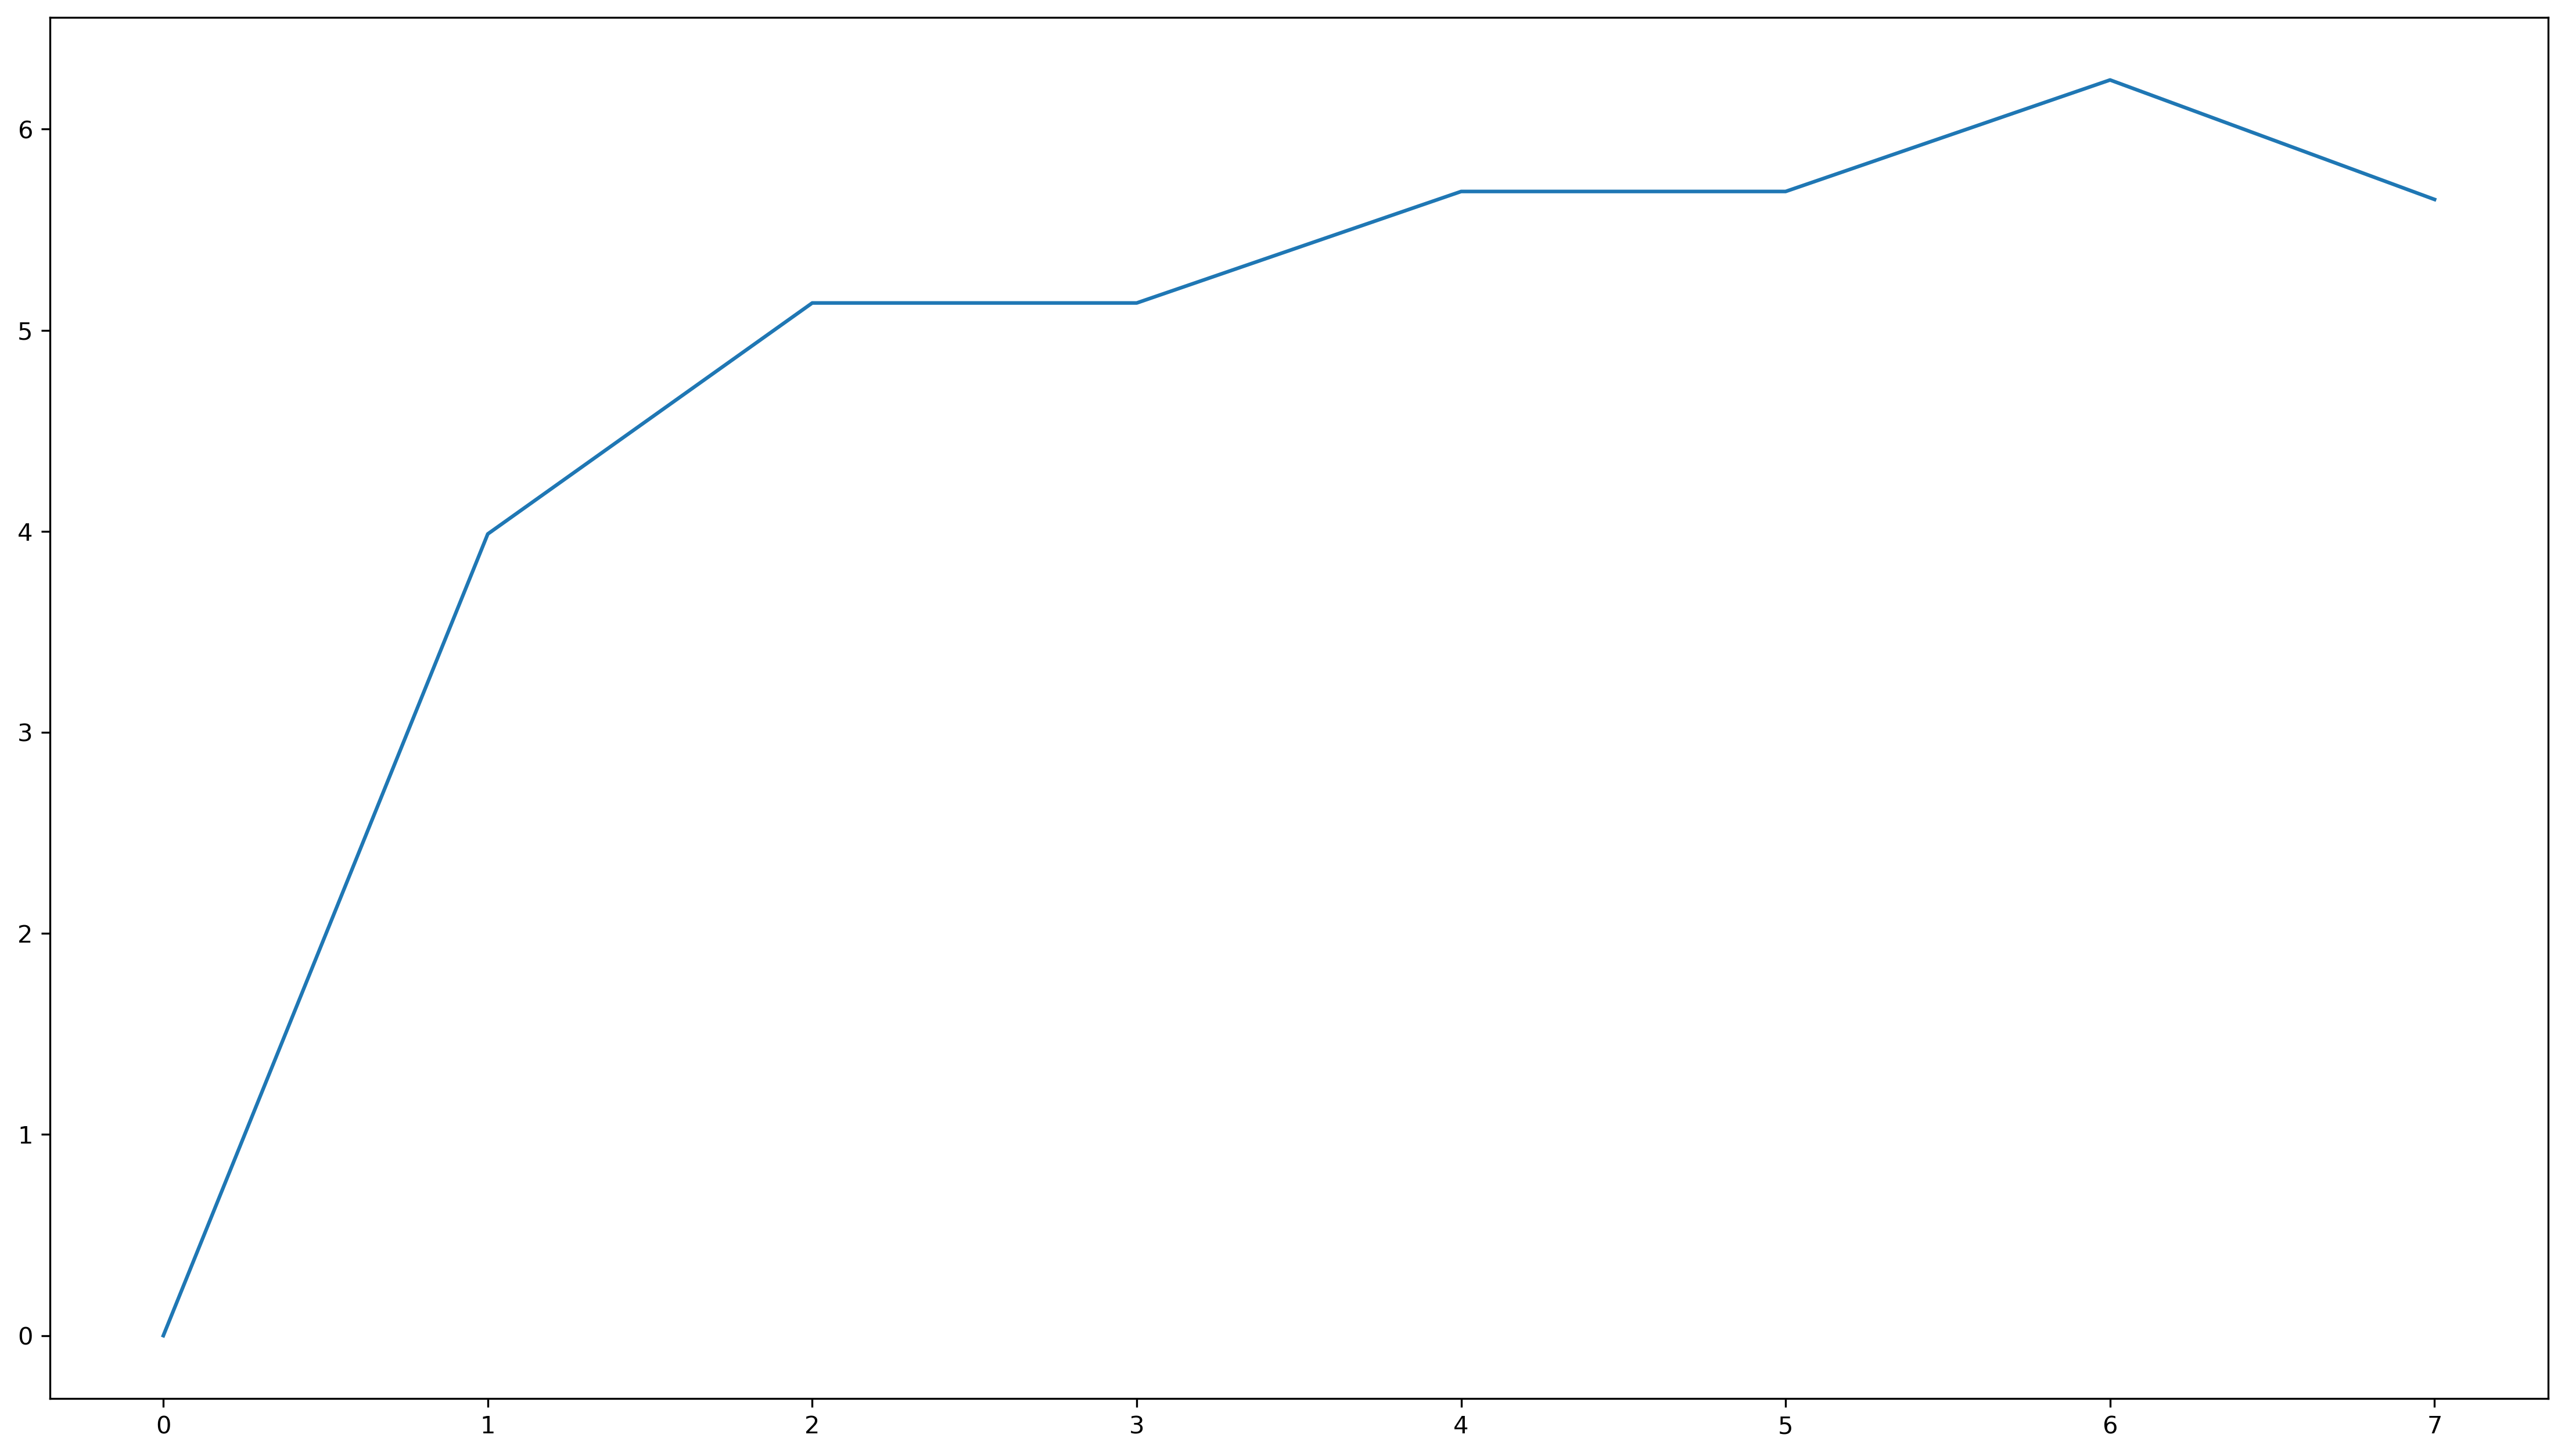

In [256]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(cost_log)), cost_log)
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(300)

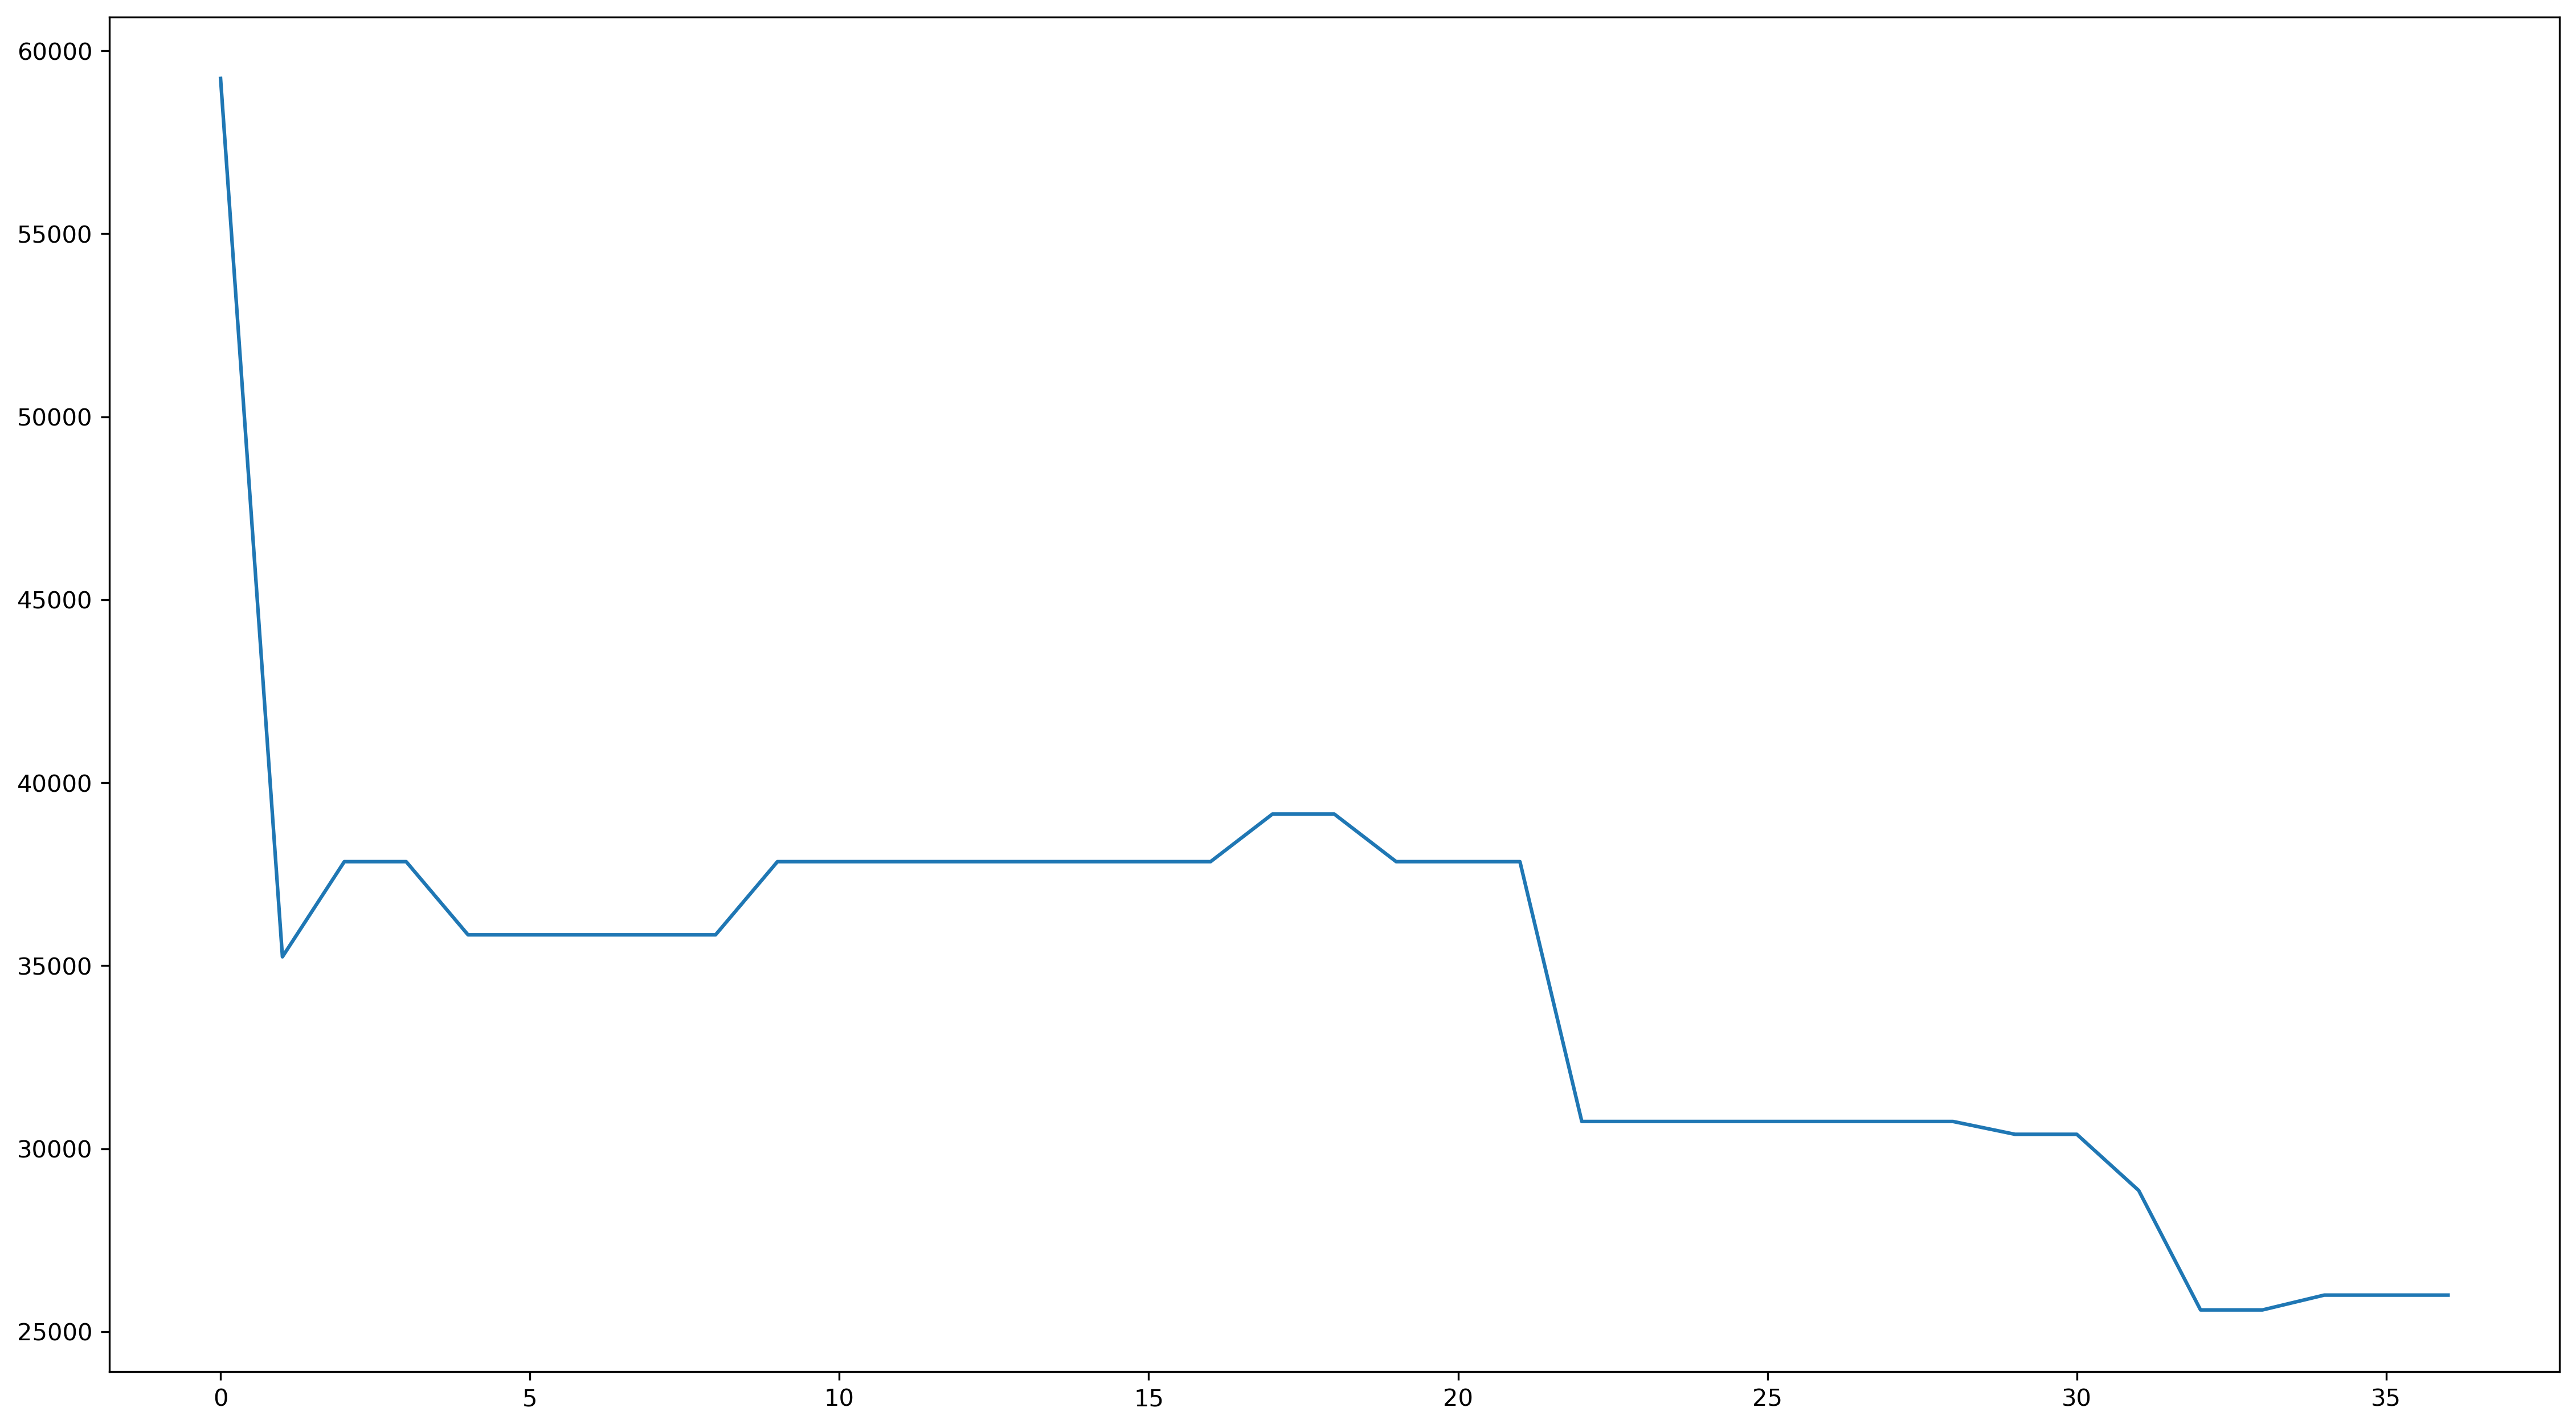

In [12]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(cost_log)), cost_log)
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(300)

In [13]:
print(cost_best)

25593


In [14]:
print(sum([1 for t in schedule if t == "tTTps00"]))


6000


In [15]:
l = [True, True, False]

sum([e.duration for e in tasks if e.type == TaskType.EVENT])

904

In [16]:
(lambda x : x + 1)(-1)

0

In [17]:
print(cost_best)

25593


In [18]:
for ps in best_ps_config:
    ppss = ps
    print(ps.name, ps.deadline, ps.duration, ps.period)

tTTps00 650 250 550


In [19]:
reduce((lambda a, b : a and b), [True, False, True, True])

False

In [20]:
a = Task("a",1,2,3,3,3)
b = Task("a",1,2,3,3,5)
l = [a,b]
for t in l:
    print(t.deadline)


c = l[0]
c.deadline = 1000
for t in l:
    print(t.deadline)

3
5
1000
5


In [21]:
int(12000 / 1100) * 650

6500

In [22]:
10 * 650

6500

In [23]:
rand.randint(0,4)

4

In [24]:
print(wcrts)

{'tTT0': 16, 'tTT1': 33, 'tTT4': 39, 'tTT5': 42, 'tTT6': 63, 'tTT11': 81, 'tTT14': 85, 'tTT18': 113, 'tTT21': 125, 'tTT24': 156, 'tTT26': 162, 'tTT27': 171, 'tTT7': 210, 'tTT8': 235, 'tTT9': 286, 'tTT10': 322, 'tTT17': 380, 'tTT19': 439, 'tTT20': 444, 'tTT23': 592, 'tTT25': 594, 'tTT28': 674, 'tTT2': 703, 'tTT3': 704, 'tTT12': 835, 'tTT13': 842, 'tTT15': 859, 'tTT16': 874, 'tTT22': 880, 'tTT29': 884}


In [25]:
sum_ = 0
for e in tasks:
    if e.type == TaskType.EVENT:
        print(e.duration, e.deadline, e.period)
        sum_ = sum_ + int(12000 / e.period) * e.duration
        
sum_

109 3847 4000
119 3824 4000
48 3655 4000
141 3224 4000
74 2819 4000
10 2394 3000
4 2266 3000
81 2106 4000
14 2073 3000
55 1864 2000
4 1813 2000
14 1793 2000
55 1773 2000
9 1581 2000
24 1509 2000
6 1348 2000
26 1145 2000
9 1121 2000
25 1117 2000
77 1103 2000


3652

In [26]:
calculate_schedulabiltiy(ppss,  [et for et in tasks if et.type==TaskType.EVENT])

True

In [27]:
ppss.et_subset

In [30]:
is_schedulable = reduce((lambda a, b : a and b), [calculate_schedulabiltiy(ps, ps.et_subset) for ps in [ppss]])
is_schedulable

True

In [29]:
cost_log

[59246,
 35243,
 37843,
 37843,
 35843,
 35843,
 35843,
 35843,
 35843,
 37843,
 37843,
 37843,
 37843,
 37843,
 37843,
 37843,
 37843,
 39143,
 39143,
 37843,
 37843,
 37843,
 30743,
 30743,
 30743,
 30743,
 30743,
 30743,
 30743,
 30393,
 30393,
 28858,
 25593,
 25593,
 25999,
 25999,
 25999]

In [3]:
l = [12,341]
type(copy.deepcopy(l))

list

In [ ]:
l = [calculate_schedulabiltiy(ps, ps.et_subset) for ps in polling_servers]
is_schedulable = reduce((lambda a, b : a and b), element[0] for element in l)

In [11]:
# cost is sum of wcrts for et and tt ?? somehow weighted maybe bc different priorities??? 
# normalize, adjust to temperature. So normalize so that it decreases.  we do not want cost 
# to dominate temperature.??? same normalize wrcts to be between 0 and 1 like divide with deadline for each
# and divide w 
# multiple response times 
# neighborhood f - like what steps. initial config randomly generated???? 
# how to like check if what we write makes sense, like if our edf works, can we compare with some reference output

# accept non feasible solution - like add some penalty 

# neighboorhod thing seems ok 
# look into unittest for vscode 

In [23]:
cases = loader.load_test_case("inf_30_30", 0)
ets = [c for c in cases if c.type == TaskType.EVENT]
ps = Task("tTTps00", 1000, 1000, TaskType.TIME, 7, 1000, et_subset=ets)
polling_servers = [ps]    
l = [calculate_schedulabiltiy(ps, ps.et_subset) for ps in polling_servers]
is_schedulable = reduce((lambda a, b : a and b), [element[0] for element in l])


Searching for test cases at:
./test_cases/inf_30_30
Loaded case_group: inf_30_30 - case: 0 test case(s).


In [24]:
is_schedulable

True

In [54]:
sum_wcrts_et = sum([sum([element[1][key] for key in element[1]]) for element in l])
sum_wcrts_et

0

In [122]:


ting, wcrts = edf1([t for t in cases if t.type == TaskType.TIME ])
normal_ = sum((wcrts[t][0] / wcrts[t][1]) for t in wcrts)

print(normal_)
print(normal_ / sum([wcrts[t][1] for t in wcrts]))

2.19975
8.269736842105262e-06


In [109]:
type(ting)

list

In [111]:
for t in wcrts:
    print(wcrts[t])

(16, 12000)
(33, 12000)
(39, 12000)
(42, 12000)
(63, 12000)
(81, 12000)
(85, 12000)
(113, 12000)
(125, 12000)
(156, 12000)
(162, 12000)
(171, 12000)
(210, 9000)
(235, 9000)
(286, 9000)
(322, 9000)
(380, 9000)
(439, 9000)
(444, 9000)
(592, 9000)
(594, 9000)
(674, 9000)
(703, 4000)
(704, 4000)
(835, 4000)
(842, 4000)
(859, 4000)
(874, 4000)
(880, 4000)
(884, 4000)


In [120]:
ting, wcrts = edf1([t for t in cases if t.type == TaskType.TIME ])
normal_ = sum((wcrts[t][0] / wcrts[t][1]) for t in wcrts)


In [124]:
ll = [(1,2), ("a","b")]

for a, b in ll:
    print(a,b)

1 2
a b


In [257]:
cases = loader.load_test_case("inf_30_30", 0)

Searching for test cases at:
./test_cases/inf_30_30
Loaded case_group: inf_30_30 - case: 0 test case(s).


In [265]:
tt = [t for t in cases if t.type == TaskType.TIME]

for t in tt:
    print(t.name, t.deadline)

tTT0 2000
tTT1 2000
tTT2 4000
tTT3 4000
tTT4 2000
tTT5 2000
tTT6 2000
tTT7 3000
tTT8 3000
tTT9 3000
tTT10 3000
tTT11 2000
tTT12 4000
tTT13 4000
tTT14 2000
tTT15 4000
tTT16 4000
tTT17 3000
tTT18 2000
tTT19 3000
tTT20 3000
tTT21 2000
tTT22 4000
tTT23 3000
tTT24 2000
tTT25 3000
tTT26 2000
tTT27 2000
tTT28 3000
tTT29 4000
